In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import math

pd.set_option('display.max_columns', None)  # Geen limiet op aantal kolommen
pd.set_option('display.width', 1000)        # Maak de 'virtuele' pagina heel breed
pd.set_option('display.max_colwidth', 50)   # Kort hele lange cel-inhoud (zoals die lijsten) iets in voor de leesbaarheid

In [26]:
#Constants

Dn50 = 0.04
g = 9.81

measurement_time1 = 60*30
measurement_time2 = 60*20

alpha_deg = np.degrees(np.arctan(4/3))
tan_alpha = np.tan(np.radians(alpha_deg))
arccot = 0.75

toe_w = 0.083    
toe_h = 0.055         
toe_sh = 3       
toe_sv = 4

#Hydrodynamics

Hs = 0.11
Hs_range = np.append(np.linspace(0.9 * Hs, 1.3 * Hs, 3), np.linspace(1.4*Hs, 1.5*Hs, 2))
Hs_range2 = np.append(np.linspace(0.6 * Hs, 1 * Hs, 3), np.linspace(1.1*Hs, 1.2*Hs, 2))
print(Hs_range)
print(Hs_range2)
water_levels = np.array([0, 0.03])
steepness = np.array([0.02, 0.04])

#Gemometry

chute_width = 0.1

crest_height = 0.48
berm_height = 0.34
berm_width = np.array([4*Dn50, 8*Dn50])
berm_level = crest_height - berm_height

def Rc(water_levels, crest_height, berm_height):
    Rc = crest_height - (berm_height + water_levels)
    Rc_Hs = []
    for i in range(len(Hs_range)):
        Rc_Hs = np.append(Rc_Hs, Rc / Hs_range[i])
    return Rc, Rc_Hs

Rc, Rc_Hs = Rc(water_levels, crest_height, berm_height)
print(Rc)
print(Rc_Hs)

[0.099 0.121 0.143 0.154 0.165]
[0.066 0.088 0.11  0.121 0.132]
[0.14 0.11]
[1.41414141 1.11111111 1.15702479 0.90909091 0.97902098 0.76923077
 0.90909091 0.71428571 0.84848485 0.66666667]


In [27]:
import numpy as np

def q_non_breaking(Hm0, Rc, alpha, sm, berm_level, B, gamma_f=0.44):
    """
    Calculates dimensionless overtopping discharge q* for non-breaking waves.
    Formula: q* = 0.8 * (cot(alpha))^-1 * exp( -2.5 * (Rc - 0.4*Hm0) / (gammas * xi^0.24 * Hm0) )
    """
    
    # ... (jouw eerdere berekeningen voor xi_m_1_0, term1, term2) ...
    xi_m_1_0 = tan_alpha / np.sqrt(sm)
    term1 = ((sm * B)/Hm0)**1.3
    term2 = (berm_level/(sm*Rc))**0.2
    
    # Bereken gamma_b
    gamma_b_raw = 1 - 18 * term1 * (1 - 0.34 * term2)
    
    # --- FIX: BEGRENZEN GAMMA_B ---
    # Voorkom dat gamma_b negatief wordt. Een veilige ondergrens is 0.6.
    gamma_b = np.maximum(0.6, gamma_b_raw)
    
    Rc_Hs = Rc / Hm0
    
    # ... (rest van je code voor exponent en q_star) ...
    numerator = 2.4 * Rc
    denominator = gamma_f * gamma_b * Hm0
    
    exponent = - (numerator / denominator)
    
    # (cot^-1 alpha) is interpreted as 1/cot(alpha) = tan(alpha)
    q_star = 0.016 * (1/sm) * np.exp(exponent)
   
    return q_star, gamma_b, Rc_Hs

In [29]:
import pandas as pd
import numpy as np

def calculate_overtopping_results(water_levels_input, hs_range_input, measurement_time_input):
    """
    Draait de overslagberekening voor opgegeven waterstanden en golfhoogtes.
    """
    data_rows = []
    
    # Zorg dat water_levels_input altijd een lijst/array is (voor als je 1 getal invoert)
    if np.isscalar(water_levels_input):
        water_levels_input = [water_levels_input]

    for wl in water_levels_input:
        # Calculate dimensional freeboard Rc (m)
        rc_m = crest_height - (berm_height + wl)
        
        for val_hs in hs_range_input:
            for sm in steepness:
                for bw in berm_width:
                    
                    # We need alpha in radians for the np.tan() inside your function to work correctly
                    alpha_rad = np.radians(alpha_deg)
                    
                    # Call your function q_non_breaking (gebruikt globale scope parameters zoals crest_height)
                    q_star_val, gamma_b, Rc_Hs = q_non_breaking(
                        Hm0=val_hs,
                        Rc=rc_m,
                        alpha=alpha_rad,
                        sm=sm,
                        berm_level=berm_level,
                        B=bw
                    )
                    
                    # Calculate actual discharge q (m^3/s/m)
                    q_actual = q_star_val * np.sqrt(g * val_hs**3)
                    
                    # Calculate Volume
                    volume = q_actual * chute_width * measurement_time1
                    
                    data_rows.append({
                        'WaterLevel': wl,
                        'Rc_m': round(rc_m, 3),
                        'Hm0': round(val_hs, 4),
                        'Steepness': sm,
                        'BermWidth': bw,
                        'BermLevel': round(berm_level, 3),
                        'q_star': q_star_val,
                        'q_discharge': q_actual,
                        'Volume': volume,
                        'Gamma_b': gamma_b,
                        'Rc/Hs': Rc_Hs
                    })

    # Return as DataFrame
    return pd.DataFrame(data_rows)


# --- SITUATIE 1: Waterstand 0, Hs_range (0.6-1.2 Hs), Tijd 1 ---
df_situation1 = calculate_overtopping_results(
    water_levels_input=water_levels[0],            # Eerste waterniveau uit je lijst
    hs_range_input=Hs_range,           # Eerste set golfhoogtes
    measurement_time_input=measurement_time1
)

# --- SITUATIE 2: Waterstand 0.03, Hs_range2 (0.4-1.2 Hs), Tijd 2 ---
df_situation2 = calculate_overtopping_results(
    water_levels_input=water_levels[1],         # Tweede waterniveau uit je lijst
    hs_range_input=Hs_range2,          # Tweede set golfhoogtes
    measurement_time_input=measurement_time1
)

# Optioneel: Alles samenvoegen in één tabel
df_total = pd.concat([df_situation1, df_situation2], ignore_index=True)

df_situation1_max = df_situation1.sort_values(by='Volume', ascending=False)
df_situation1_min = df_situation1.sort_values(by='Volume')

# Sorteren en printen
df_situation2_max = df_situation2.sort_values(by='Volume', ascending=False)
df_situation2_min = df_situation2.sort_values(by='Volume')

print(df_situation1_max)

    WaterLevel  Rc_m    Hm0  Steepness  BermWidth  BermLevel    q_star   q_discharge    Volume   Gamma_b     Rc/Hs
16         0.0  0.14  0.165       0.02       0.16       0.14  0.006862  1.440416e-03  0.259275  0.972562  0.848485
17         0.0  0.14  0.165       0.02       0.32       0.14  0.005591  1.173712e-03  0.211268  0.932440  0.848485
12         0.0  0.14  0.154       0.02       0.16       0.14  0.004819  9.121092e-04  0.164180  0.969988  0.909091
13         0.0  0.14  0.154       0.02       0.32       0.14  0.003782  7.158731e-04  0.128857  0.926101  0.909091
8          0.0  0.14  0.143       0.02       0.16       0.14  0.003196  5.413563e-04  0.097444  0.966952  0.979021
18         0.0  0.14  0.165       0.04       0.16       0.14  0.002434  5.108509e-04  0.091953  0.907092  0.848485
9          0.0  0.14  0.143       0.02       0.32       0.14  0.002390  4.048653e-04  0.072876  0.918627  0.979021
14         0.0  0.14  0.154       0.04       0.16       0.14  0.001603  3.034149

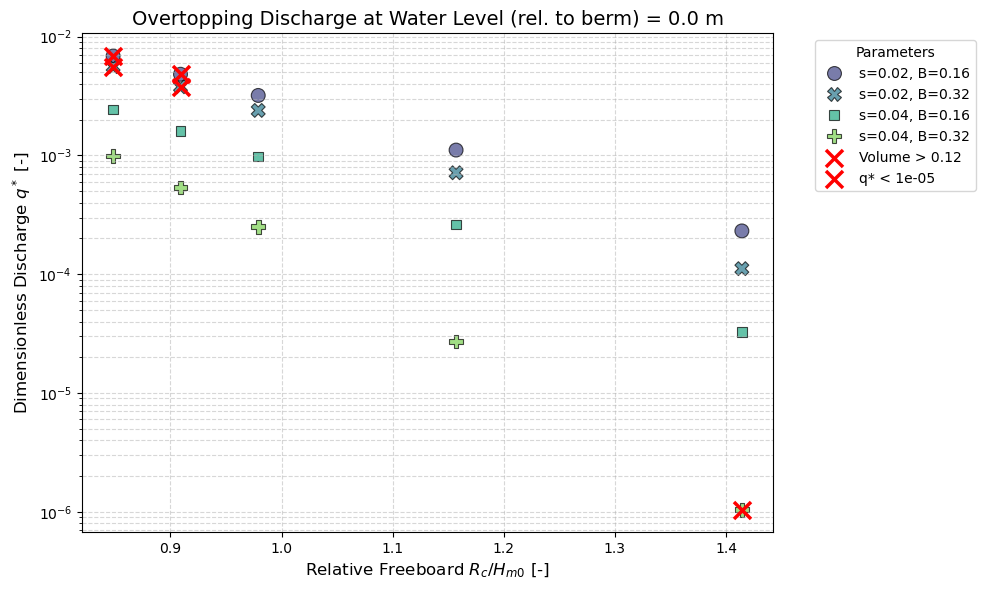

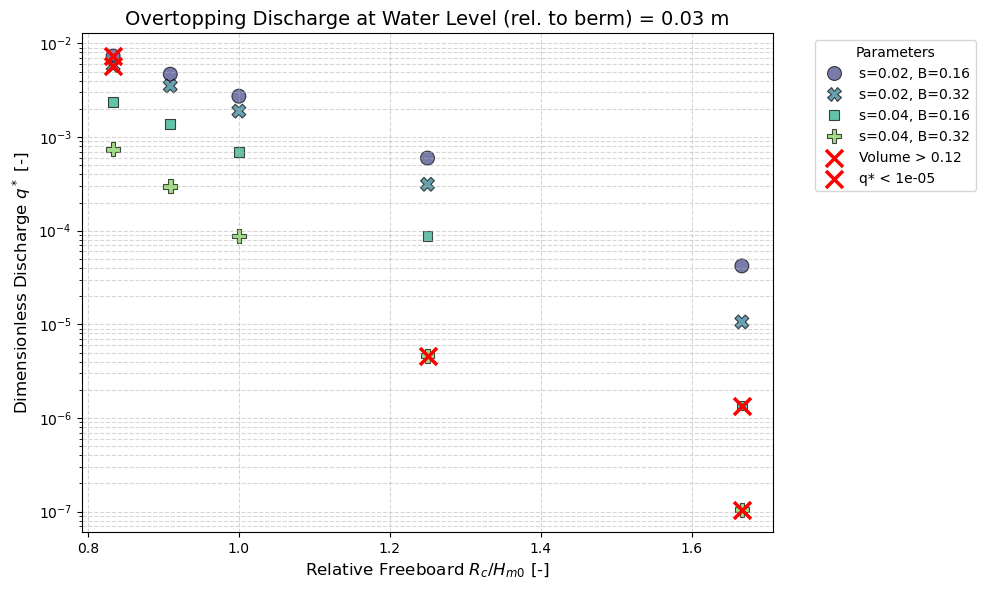

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_overtopping_combined_constraints(df):
    # Unieke waterstanden ophalen
    water_levels_unique = df['WaterLevel'].unique()
    
    # Voor elke waterstand een aparte plot maken
    for wl in water_levels_unique:
        # Filter de data voor deze specifieke waterstand
        df_subset = df[df['WaterLevel'] == wl].copy()
        
        # Maak label kolom
        df_subset['Label'] = (
            's=' + df_subset['Steepness'].astype(str) + 
            ', B=' + df_subset['BermWidth'].apply(lambda x: f"{x:.2f}")
        )
        
        # Plot initialiseren
        plt.figure(figsize=(10, 6))
        
        # 1. DE BASIS PLOT (Alle punten)
        sns.scatterplot(
            data=df_subset,
            x='Rc/Hs',
            y='q_star',
            hue='Label',
            style='Label',
            palette='viridis',
            s=100,
            edgecolor='black',
            alpha=0.7
        )
        
        # 2. CONSTRAINT A: HOOG VOLUME (> 0.12)
        df_high_vol = df_subset[df_subset['Volume'] > 0.12]
        
        if not df_high_vol.empty:
            plt.scatter(
                x=df_high_vol['Rc/Hs'],
                y=df_high_vol['q_star'],
                color='red',            
                s=150,                  
                marker='x',             
                linewidth=2.5,          
                label='Volume > 0.12', 
                zorder=10               
            )

        # 3. CONSTRAINT B: LAGE q* (< 10^-5)
        # Hier aangepast naar 1e-5 zoals gevraagd
        threshold_q = 1e-5
        df_low_q = df_subset[df_subset['q_star'] < threshold_q]
        
        if not df_low_q.empty:
            plt.scatter(
                x=df_low_q['Rc/Hs'],
                y=df_low_q['q_star'],
                color='red',            
                s=150,                  
                marker='x',             
                linewidth=2.5,          
                label=f'q* < {threshold_q}', # Label in legenda
                zorder=10               
            )

        # Logaritmische schaal
        plt.yscale('log')
        
        # Raster en lijnen (geen threshold lijn meer)
        plt.grid(True, which="both", ls="--", alpha=0.5)
        
        # Titels en as-labels
        plt.title(f'Overtopping Discharge at Water Level (rel. to berm) = {wl} m', fontsize=14)
        plt.xlabel(r'Relative Freeboard $R_c / H_{m0}$ [-]', fontsize=12)
        plt.ylabel(r'Dimensionless Discharge $q^*$ [-]', fontsize=12)
        
        # Legenda
        plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()

# Functies aanroepen
plot_overtopping_combined_constraints(df_situation1)
plot_overtopping_combined_constraints(df_situation2)

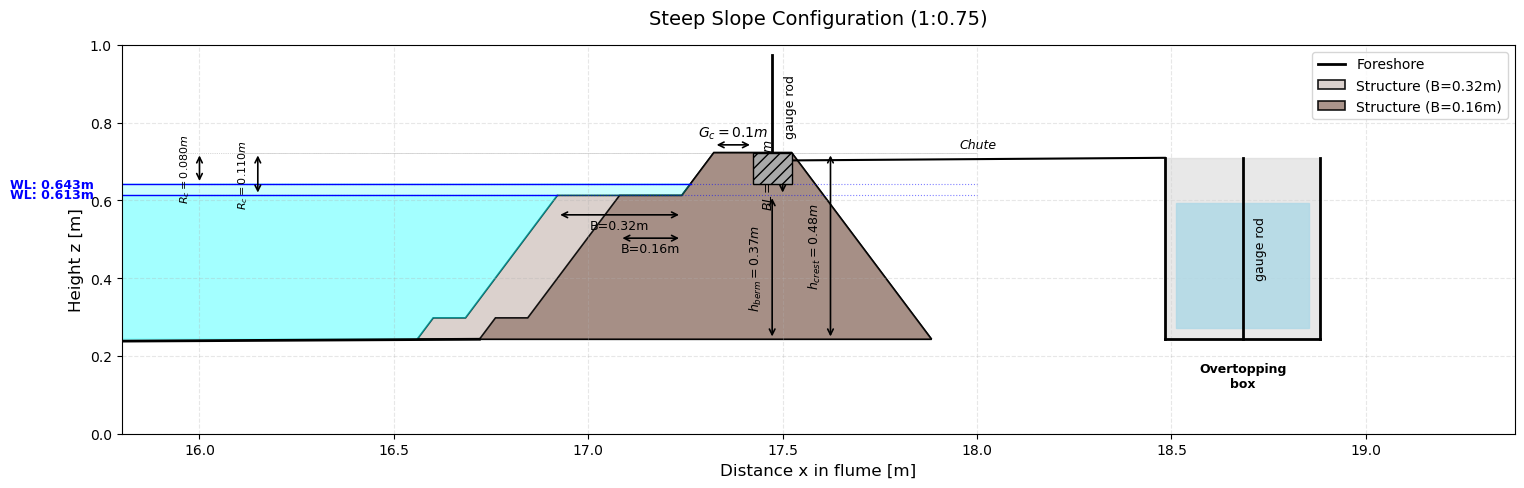

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. VASTE DATA (BATHYMETRIE) ---
# Start z van de constructie is de laatste waarde van z_fixed (0.243 m)
x_fixed = np.array([0.0, 5.0, 5.91, 7.5, 10.0, 12.5, 15.0, 16.72])
z_fixed = np.array([0.0, 0.0, 0.0, 0.159, 0.209, 0.221, 0.234, 0.243])

# Rc functie
def Rc(water_levels, crest_height, berm_height):
    Rc = crest_height - (berm_height + water_levels)
    Rc_Hs = []
    for i in range(len(Hs_range)):
        Rc_Hs = np.append(Rc_Hs, Rc / Hs_range[i])
    return Rc, Rc_Hs

Rc_val, Rc_Hs_val = Rc(water_levels, crest_height, berm_height)


# --- 3. DE PLOT FUNCTIE ---
def plot_breakwater_final_geometry(
    bh_rel, crest_h_rel, widths, hb_list, label_offsets,
    toe_w, toe_h, toe_sh, toe_sv, main_slope,
    x_bathy, z_bathy, toe_level,
    title,
    gc_width=0.10
):
    # Absolute hoogtes berekenen (Relatief + Bodemhoogte)
    bh_abs = bh_rel + toe_level        
    crest_h_abs = crest_h_rel + toe_level 
    
    # Figuur aanmaken
    fig, ax = plt.subplots(figsize=(16, 8))
    
    fill_colors = ['#D7CCC8', '#A1887F']
    sorted_widths = sorted(widths, reverse=True) 
    min_width = sorted_widths[-1] 
    
    start_x_foreshore = x_bathy[-1] 
    start_z = z_bathy[-1] # Dit moet gelijk zijn aan toe_level
    toe_slope_ratio = toe_sh / toe_sv
    
    # AFMETINGEN ELEMENTEN
    block_length = 0.10
    block_height = 0.08

    # --- 1. BEREKEN GEOMETRIE ---
    dx_toe_front = toe_h * toe_slope_ratio
    dx_to_berm = (bh_abs - (start_z + toe_h)) * main_slope
    dx_to_crest = (crest_h_abs - bh_abs) * main_slope
    
    # VAST ANKERPUNT (Kruin Start)
    x_crest_start_fixed = start_x_foreshore + dx_toe_front + toe_w + dx_to_berm + min_width + dx_to_crest
    x_crest_total_end = x_crest_start_fixed + gc_width + block_length
    
    # --- ACHTERTALUD ---
    dx_rear_slope = (crest_h_abs - start_z) * main_slope 
    x_rear_toe = x_crest_total_end + dx_rear_slope       
    
    # BOX PARAMETERS
    gap_to_box = 0.6  
    box_x_start = x_rear_toe + gap_to_box                  
    box_width = 0.40 
    box_height = 0.7 / 1.5
    box_wall_thick = 0.03
    
    # --- A. BATHYMETRY ---
    plot_min_x = 15.5 
    mask = x_bathy >= 10.0 
    ax.plot(x_bathy[mask], z_bathy[mask], color='black', lw=2, label='Foreshore')
    ax.plot([plot_min_x, x_bathy[mask][0]], [z_bathy[mask][0], z_bathy[mask][0]], color='black', lw=2)
    
    widest_profile_coords = {} 

    # --- B. CONSTRUCTIE LOOP ---
    for i, B in enumerate(sorted_widths):
        x_poly = []
        z_poly = []
        
        # REKENEN VAN RECHTS NAAR LINKS
        x_berm_end = x_crest_start_fixed - dx_to_crest
        x_berm_start = x_berm_end - B
        x_toe_back = x_berm_start - dx_to_berm
        z_toe_top = start_z + toe_h
        x_toe_top_start = x_toe_back - toe_w
        x_structure_start = x_toe_top_start - dx_toe_front
        
        # POLYGOON BOUWEN
        x_poly.append(x_structure_start); z_poly.append(start_z)
        x_poly.append(x_toe_top_start);   z_poly.append(z_toe_top)
        x_poly.append(x_toe_back);        z_poly.append(z_toe_top)
        x_poly.append(x_berm_start);      z_poly.append(bh_abs)
        x_poly.append(x_berm_end);        z_poly.append(bh_abs)
        x_poly.append(x_crest_start_fixed); z_poly.append(crest_h_abs)
        x_poly.append(x_crest_total_end);   z_poly.append(crest_h_abs)
        
        # ACHTERTALUD
        x_poly.append(x_rear_toe);        z_poly.append(start_z) 
        x_poly.append(x_structure_start); z_poly.append(start_z)

        ax.fill(x_poly, z_poly, color=fill_colors[i % 2], 
                label=f'Structure (B={B:.2f}m)', alpha=0.9, edgecolor='black', linewidth=1.2)
        
        if i == 0:
            widest_profile_coords = {
                'start_x': x_structure_start, 'toe_top_start': x_toe_top_start,
                'toe_back': x_toe_back, 'berm_start': x_berm_start, 'berm_end': x_berm_end,
                'toe_z': z_toe_top
            }

        # PIJLEN: BERM BREEDTE
        z_arrow_depth = 0.05 + (i * 0.06) 
        z_arrow = bh_abs - z_arrow_depth
        ax.annotate('', xy=(x_berm_start, z_arrow), xytext=(x_berm_end, z_arrow),
                    arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
        ax.text((x_berm_start + x_berm_end)/2, z_arrow - 0.01, f'B={B:.2f}m', 
                ha='center', va='top', fontsize=9, color='black')

        # --- DETAIL TEKENINGEN ---
        if i == len(sorted_widths) - 1:
            # Betonblok
            x_block_start = x_crest_start_fixed + gc_width
            x_block_end = x_block_start + block_length
            rect_x = [x_block_start, x_block_end, x_block_end, x_block_start]
            rect_y = [crest_h_abs - block_height, crest_h_abs - block_height, crest_h_abs, crest_h_abs]
            ax.fill(rect_x, rect_y, color='darkgrey', hatch='///', edgecolor='black', zorder=10)

            # Gc Maatvoering
            dim_h_gc = crest_h_abs + 0.02 
            ax.annotate('', xy=(x_crest_start_fixed, dim_h_gc), xytext=(x_block_start, dim_h_gc),
                        arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
            ax.text((x_crest_start_fixed + x_block_start)/2, dim_h_gc + 0.01, 
                    f'$G_c={gc_width}m$', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

            # Gauge Rod & Chute
            rod_x = x_block_start + (block_length / 2)
            ax.plot([rod_x, rod_x], [crest_h_abs, crest_h_abs + 0.25], color='black', lw=2)
            ax.text(rod_x + 0.03, crest_h_abs + 0.12, 'gauge rod', rotation=90, va='center', ha='left', fontsize=9, color='black')
            
            # Chute
            ax.plot([x_block_end, box_x_start], [crest_h_abs - 0.02, start_z + box_height], color='black', lw=1.5)
            mid_chute_x = (x_block_end + box_x_start) / 2
            mid_chute_z = (crest_h_abs - 0.02 + start_z + box_height) / 2
            ax.text(mid_chute_x, mid_chute_z + 0.02, 'Chute', ha='center', va='bottom', fontsize=9, fontstyle='italic')

    # --- Z. OVERTOPPING BOX ---
    ax.plot([box_x_start, box_x_start], [start_z + box_height, start_z], color='black', lw=2, zorder=5)
    ax.plot([box_x_start, box_x_start + box_width], [start_z, start_z], color='black', lw=2, zorder=5)
    ax.plot([box_x_start + box_width, box_x_start + box_width], [start_z, start_z + box_height], color='black', lw=2, zorder=5)
    
    box_x_poly = [box_x_start, box_x_start + box_width, box_x_start + box_width, box_x_start]
    box_y_poly = [start_z + box_height, start_z + box_height, start_z, start_z]
    ax.fill(box_x_poly, box_y_poly, color='lightgrey', alpha=0.5, zorder=4)

    # WATER & ROD IN BOX
    water_level_box = box_height * 0.75
    water_x = [box_x_start + box_wall_thick, box_x_start + box_width - box_wall_thick, 
               box_x_start + box_width - box_wall_thick, box_x_start + box_wall_thick]
    water_y = [start_z + water_level_box, start_z + water_level_box, start_z + box_wall_thick, start_z + box_wall_thick]
    ax.fill(water_x, water_y, color='lightblue', alpha=0.8, zorder=6)

    rod_box_x = box_x_start + box_width / 2
    ax.plot([rod_box_x, rod_box_x], [start_z, start_z + box_height], color='black', lw=2, zorder=7)
    ax.text(rod_box_x + 0.03, start_z + (box_height/2), 'gauge rod', 
            rotation=90, va='center', ha='left', fontsize=9, color='black', zorder=7)
    ax.text(box_x_start + box_width/2, start_z - 0.06, 'Overtopping\nbox', ha='center', va='top', fontsize=9, fontweight='bold')

    # --- C. WATER LEVELS ---
    x_view_min = plot_min_x
    wl_values = [] 
    
    w_start_x = widest_profile_coords['start_x']
    w_toe_top = widest_profile_coords['toe_top_start']
    w_toe_back = widest_profile_coords['toe_back']
    w_berm_start = widest_profile_coords['berm_start']
    w_berm_end = widest_profile_coords['berm_end']
    z_toe_top = widest_profile_coords['toe_z']

    for hb in hb_list:
        wl = bh_abs + hb # Waterstand = Absolute bermhoogte + hb (relatief aan berm)
        wl_values.append(wl)
        
        if wl <= z_toe_top:
            x_hit = w_start_x + (wl - start_z) * toe_slope_ratio
            poly_x = [x_view_min, w_start_x, x_hit, x_view_min]
            poly_y = [start_z, start_z, wl, wl]
        elif wl <= bh_abs:
            x_hit = w_toe_back + (wl - z_toe_top) * main_slope
            poly_x = [x_view_min, w_start_x, w_toe_top, w_toe_back, x_hit, x_view_min]
            poly_y = [start_z, start_z, z_toe_top, z_toe_top, wl, wl]
        else:
            x_hit = w_berm_end + (wl - bh_abs) * main_slope
            poly_x = [x_view_min, w_start_x, w_toe_top, w_toe_back, w_berm_start, w_berm_end, x_hit, x_view_min]
            poly_y = [start_z, start_z, z_toe_top, z_toe_top, bh_abs, bh_abs, wl, wl]

        ax.fill(poly_x, poly_y, color='cyan', alpha=0.2) 
        ax.plot([x_view_min, x_hit], [wl, wl], color='blue', lw=1.0) 

    # --- WATERLEVEL LABELS ---
    wl_values.sort(reverse=True)
    text_spacing = 0.025 
    start_y_txt = np.mean(wl_values) + ((len(wl_values) - 1) * text_spacing) / 2
    
    for i, wl in enumerate(wl_values):
        label_txt = f"WL: {wl:.3f}m"
        ax.text(-0.02, start_y_txt - (i * text_spacing), label_txt, 
                color='blue', va='center', ha='right', fontsize=9, fontweight='bold',
                transform=ax.get_yaxis_transform())


    # --- D. MAATVOERING ---
    x_dim_base = x_crest_start_fixed
    
    # H_crest
    x_dim_crest = x_dim_base + 0.30
    ax.annotate('', xy=(x_dim_crest, start_z), xytext=(x_dim_crest, crest_h_abs), arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
    ax.text(x_dim_crest - 0.02, (start_z + crest_h_abs)/2, f'$h_{{crest}}={crest_h_rel:.2f}m$', rotation=90, va='center', ha='right', fontsize=9)

    # H_berm
    x_dim_berm = x_dim_base + 0.15 
    ax.annotate('', xy=(x_dim_berm, start_z), xytext=(x_dim_berm, bh_abs), arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
    ax.text(x_dim_berm - 0.02, (start_z + bh_abs)/2, f'$h_{{berm}}={bh_rel:.2f}m$', rotation=90, va='center', ha='right', fontsize=9)


    # Rc (FREEBOARD)
    x_rc_fixed = 16.0
    sorted_hb_list = sorted(hb_list, reverse=True)
    rc_spacing = 0.15
    
    for i, hb in enumerate(sorted_hb_list):
        wl = bh_abs + hb
        rc_val = crest_h_abs - wl
        x_rc_curr = x_rc_fixed + (i * rc_spacing)
        
        ax.plot([x_rc_fixed, 18.0], [wl, wl], color='blue', linestyle=':', lw=0.8, alpha=0.5) 
        ax.annotate('', xy=(x_rc_curr, wl), xytext=(x_rc_curr, crest_h_abs), 
                    arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
        mid_z = (wl + crest_h_abs) / 2
        ax.text(x_rc_curr - 0.02, mid_z, f'$R_c={rc_val:.3f}m$', 
                rotation=90, va='center', ha='right', fontsize=8, color='black')
        ax.plot([x_rc_curr - 0.05, 18.0], [crest_h_abs, crest_h_abs], 'k:', lw=0.5, alpha=0.3)


    # BL (BERM LEVEL)
    x_bl_pos = 17.5
    bl_val = crest_h_rel - bh_rel 
    ax.annotate('', xy=(x_bl_pos, bh_abs), xytext=(x_bl_pos, crest_h_abs), 
                arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
    ax.text(x_bl_pos - 0.02, (bh_abs + crest_h_abs)/2, f'$BL={bl_val:.2f}m$', 
            rotation=90, va='center', ha='right', fontsize=9, fontweight='bold', color='black')


    # --- E. STYLING ---
    ax.set_title(title, fontsize=14, pad=15)
    ax.set_xlabel("Distance x in flume [m]", fontsize=12)
    ax.set_ylabel("Height z [m]", fontsize=12, y=0.45)
    
    ax.set_xlim(15.8, box_x_start + box_width + 0.5) 
    # Y-limiet iets verruimd omdat de constructie nu hoger ligt (tot ca 0.71m)
    ax.set_ylim(0, 1.0) 
    
    ax.grid(True, which='both', alpha=0.3, linestyle='--')
    ax.set_aspect('equal')
    ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.12) 
    plt.show()

# --- 4. FUNCTIE AANROEP (AANGEPAST) ---
plot_breakwater_final_geometry(
    bh_rel=berm_height,         # 0.37 (relatief)
    crest_h_rel=crest_height,   # 0.47 (relatief)
    widths=berm_width,          
    hb_list=water_levels,       
    label_offsets=[0],
    toe_w=toe_w,
    toe_h=toe_h,
    toe_sh=toe_sh,
    toe_sv=toe_sv,
    main_slope=arccot,          
    x_bathy=x_fixed,
    z_bathy=z_fixed,
    toe_level=z_fixed[-1],      # HIER IS DE FIX: toe_level is nu 0.243m
    title="Steep Slope Configuration (1:0.75)",
    gc_width=0.10
)
